In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

## 0.Load Data

In [2]:
# load EMG data
EMG_file_name='s1/S1_A1_E1.mat'
emg_data = loadmat(EMG_file_name)

print(f"What kind of data structure are we working with? {type(emg_data)}")
print(f"What are the keys of the data structure? {[key for key in emg_data.keys()]}")

What kind of data structure are we working with? <class 'dict'>
What are the keys of the data structure? ['__header__', '__version__', '__globals__', 'emg', 'stimulus', 'glove', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition']


In [3]:
glove = emg_data["glove"].copy()
extract_list = [3, 6, 8, 11, 14]
emg = glove[:, extract_list]
print(f'glove.shape={glove.shape}, emg={emg.shape}')

glove.shape=(101014, 22), emg=(101014, 5)


In [4]:
# emg= emg_data["emg"].copy()
stimulus = emg_data["restimulus"] 
repetition = emg_data["rerepetition"] 

print(f'What are the shape of the data that we are working with? \nEMG: {emg.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}')

What are the shape of the data that we are working with? 
EMG: (101014, 5), 
Stimulus (101014, 1), 
Repetition (101014, 1)


## 1. Preprocessing

### 1.1 Apply bandpass filter
Before preprocessing, we visualize the rawdata for subject2.

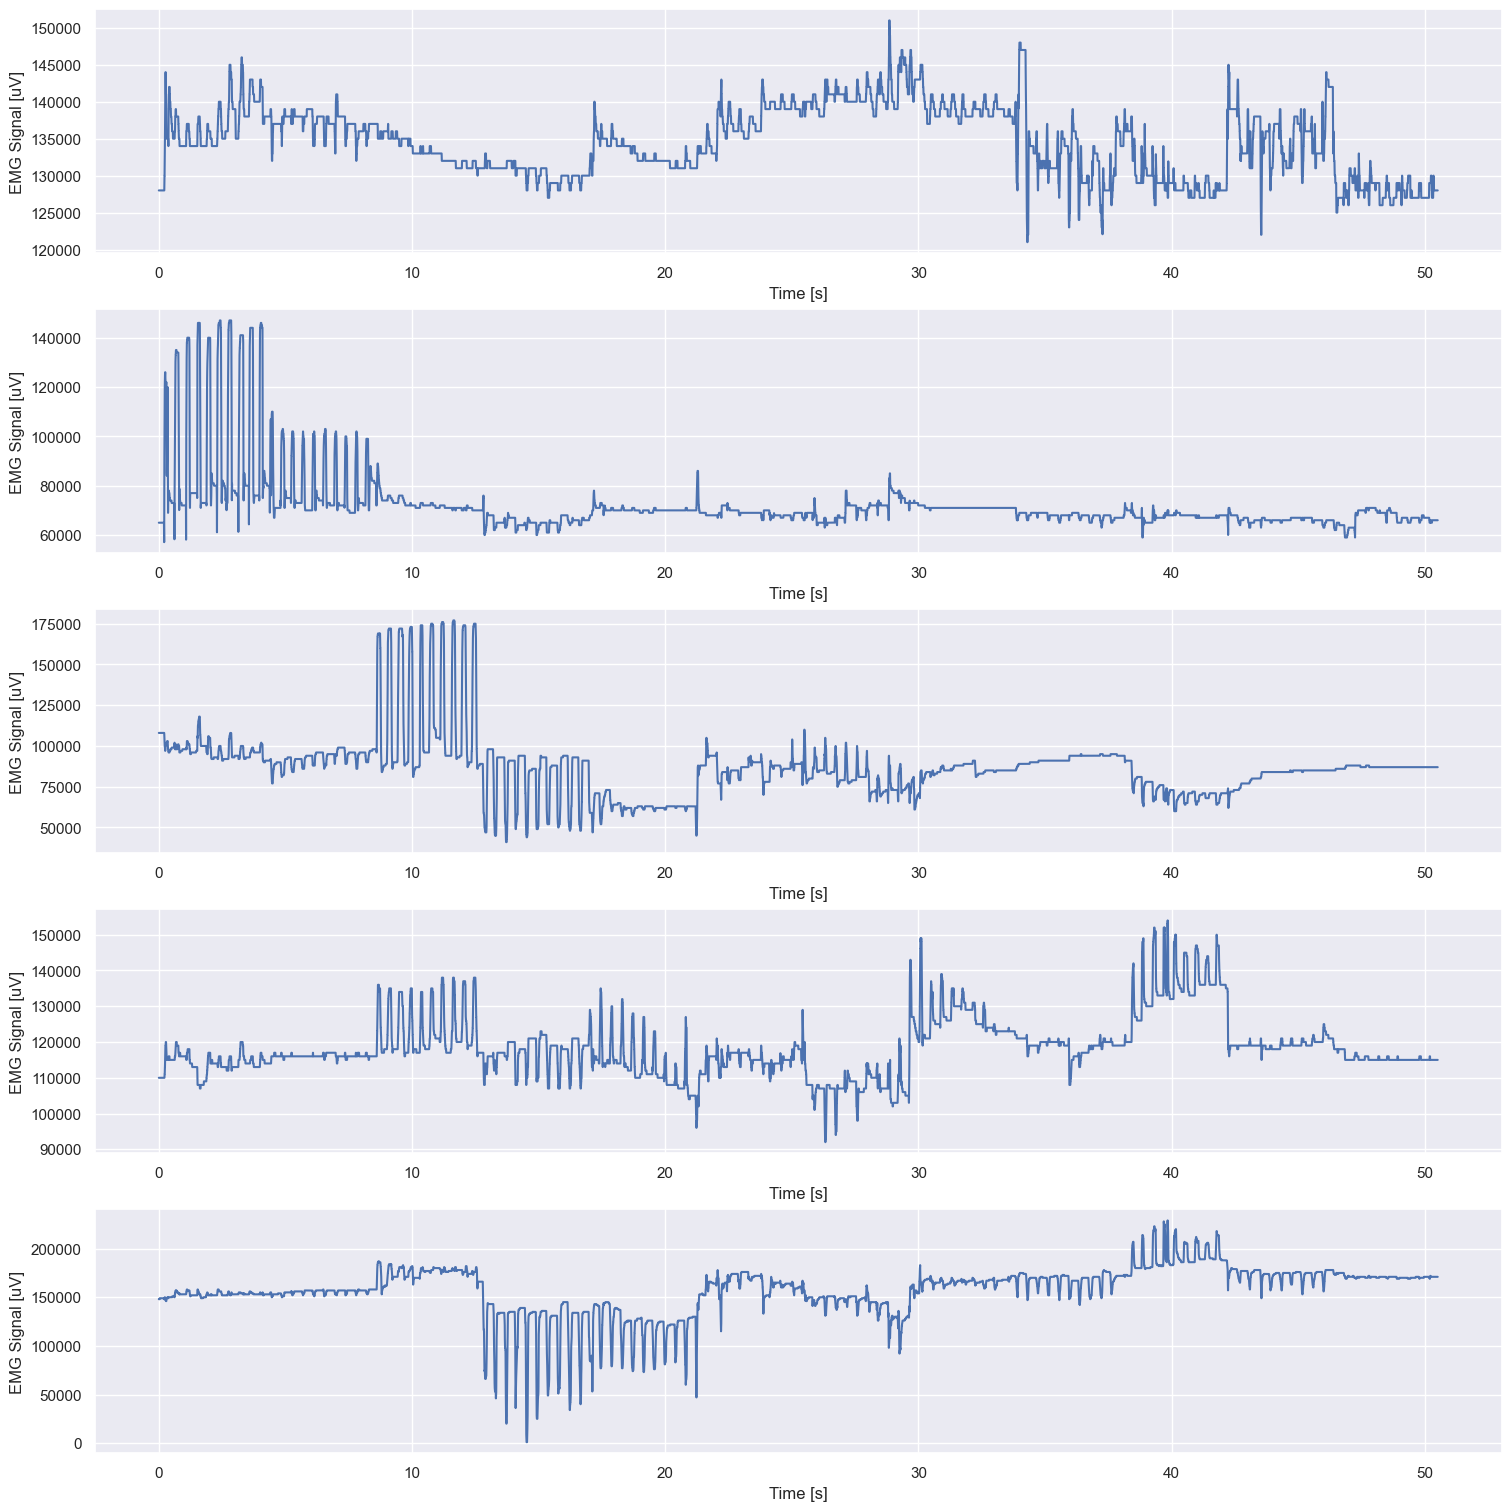

In [5]:
n_channels = emg.shape[1]

fs = 2000 # According to the references, sampling frequency here is 2000 Hz.

time_steps = np.arange(0,emg.shape[0]/fs, 1/fs)

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg[:, channel_idx]*1000)
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG Signal [uV]")

Because the sEMG data was gathered using OttoBock MyoBock 13E200 surface EMG electrodes3, it is supposed to be amplified, bandpass-filtered and rectified version of the raw sEMG signal.

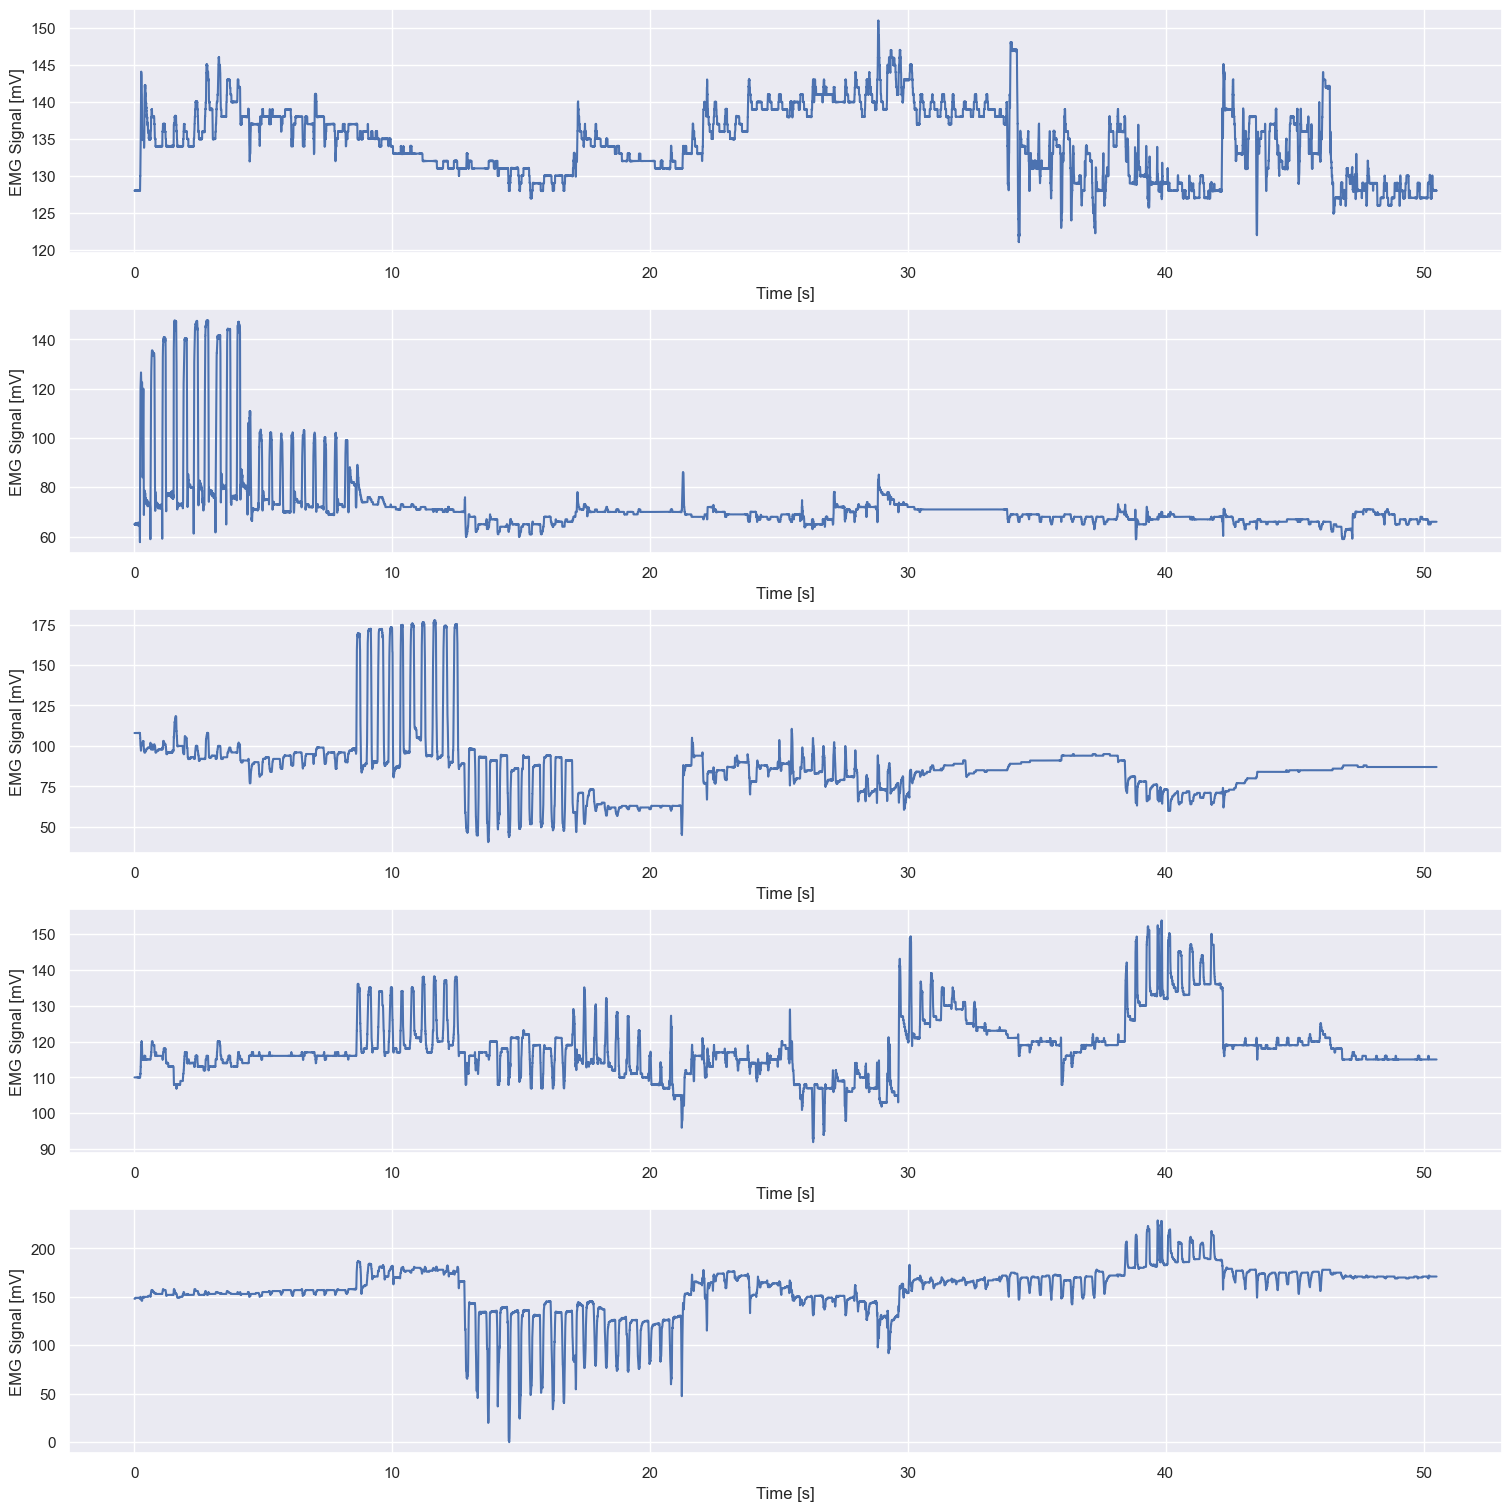

In [6]:
bandpass_cutoff_frequencies_Hz = (15, 500) 
sos = butter(N=0, Wn=bandpass_cutoff_frequencies_Hz, fs=fs, btype="bandpass", output="sos") 
emg_filtered = sosfiltfilt(sos, emg.T).T 


powergrid_noise_frequencies_Hz = [harmonic_idx*50 for harmonic_idx in range(1,3)] # removing 50Hz noise and its harmonics

for noise_frequency in powergrid_noise_frequencies_Hz:
    sos = butter(N=4, Wn=(noise_frequency - 2, noise_frequency + 2), fs=fs, btype="bandstop", output="sos")
    emg_filtered = sosfiltfilt(sos, emg_filtered.T).T

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for i in range(n_channels):
    ax[i].plot(time_steps, emg_filtered[:, i])
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("EMG Signal [mV]")

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

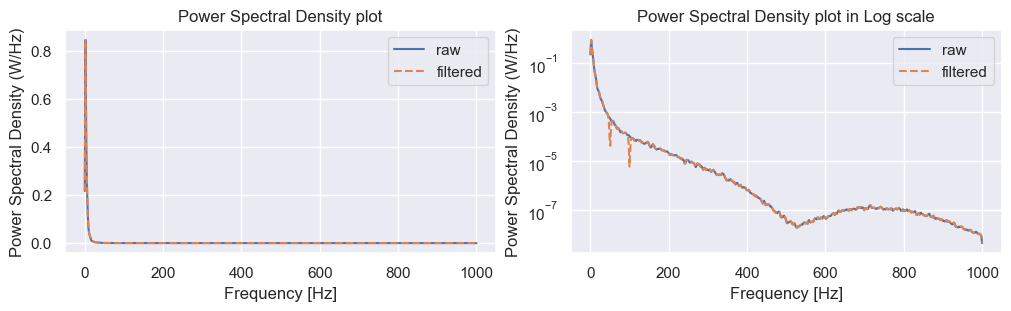

In [7]:
freqs_pre, Pxx_pre = welch(emg[:, 0], fs=fs, nperseg=1064)
freqs_post, Pxx_post = welch(emg_filtered[:, 0],fs = fs,  nperseg=1064)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].plot(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].semilogy(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

### 1.2 Rectify signals

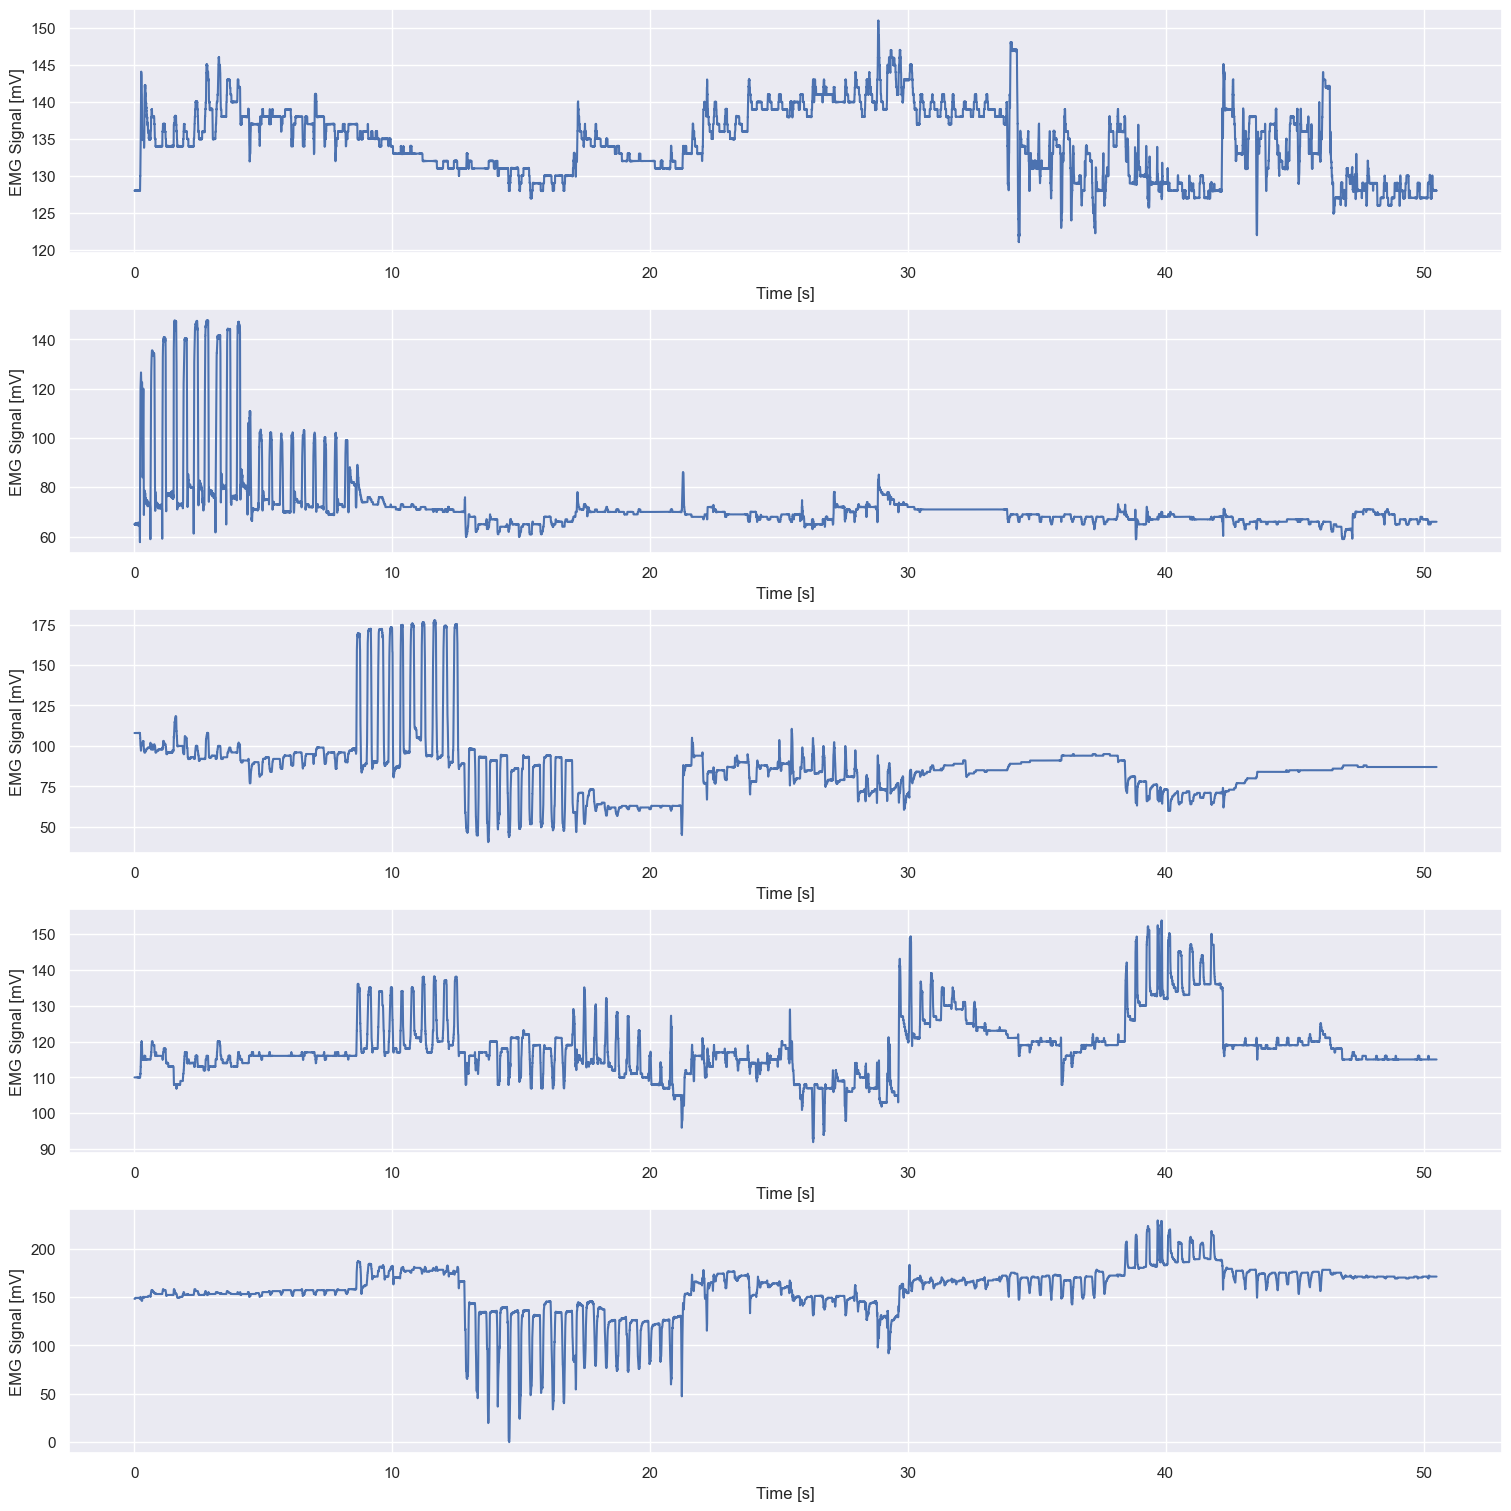

In [8]:
emg_rectified = np.abs(emg_filtered)

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_rectified[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG Signal [mV]")

In [9]:
# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg_rectified.shape[1]

print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}') 

How many types of movement are there? 12
How many repetitions are there? 10


In [10]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[305., 354., 346., 371., 438., 372., 430., 412., 435., 352.],
       [193., 388., 233., 234., 244., 252., 316., 227., 229., 302.],
       [524., 390., 481., 433., 460., 515., 199., 360., 424., 356.],
       [348., 296., 287., 276., 281., 242., 278., 315., 330., 329.],
       [452., 453., 382., 416., 376., 418., 430., 339., 318., 368.],
       [293., 305., 432., 286., 301., 306., 254., 299., 253., 329.],
       [246., 240., 266., 263., 252., 187., 259., 325., 299., 278.],
       [211., 294., 277., 359., 333., 372., 374., 287., 306., 185.],
       [197., 250., 234., 222., 295., 281., 269., 330., 289., 241.],
       [458., 184., 184., 270., 407., 188., 338., 379., 473., 306.],
       [186., 285., 305., 195., 230., 240., 222., 318., 238., 272.],
       [341., 429., 189., 239., 526., 261., 185., 521., 224., 319.]])

### 1.3 Compute the envelop of the signal

In [11]:
mov_mean_size = 200
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 

Text(0.5, 0.98, 'Envelopes of the EMG signal')

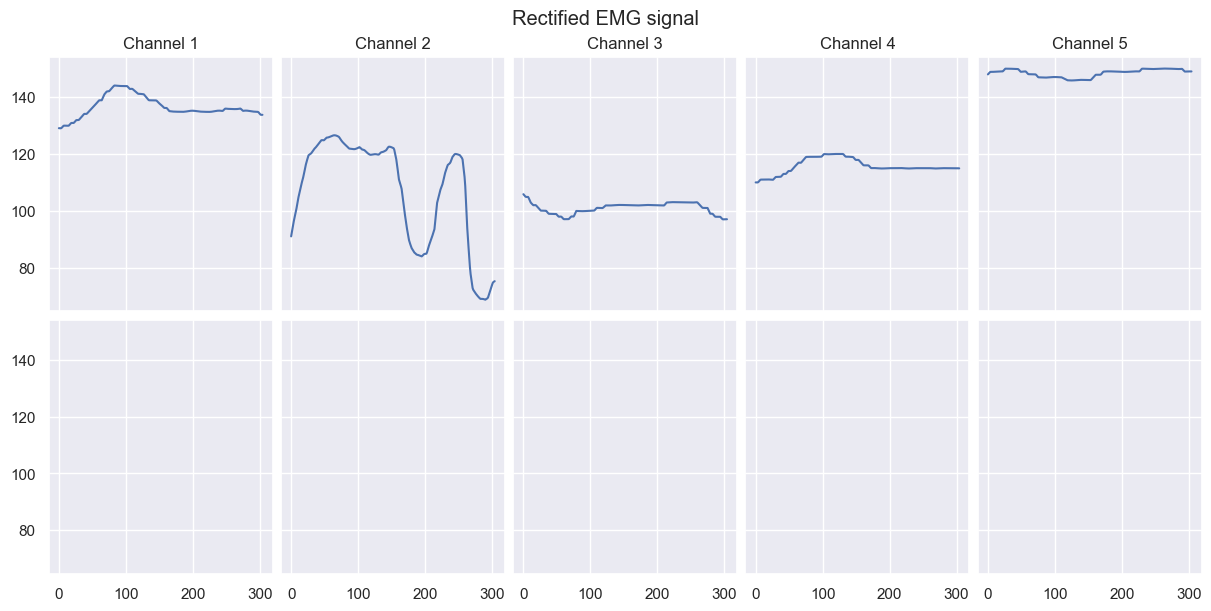

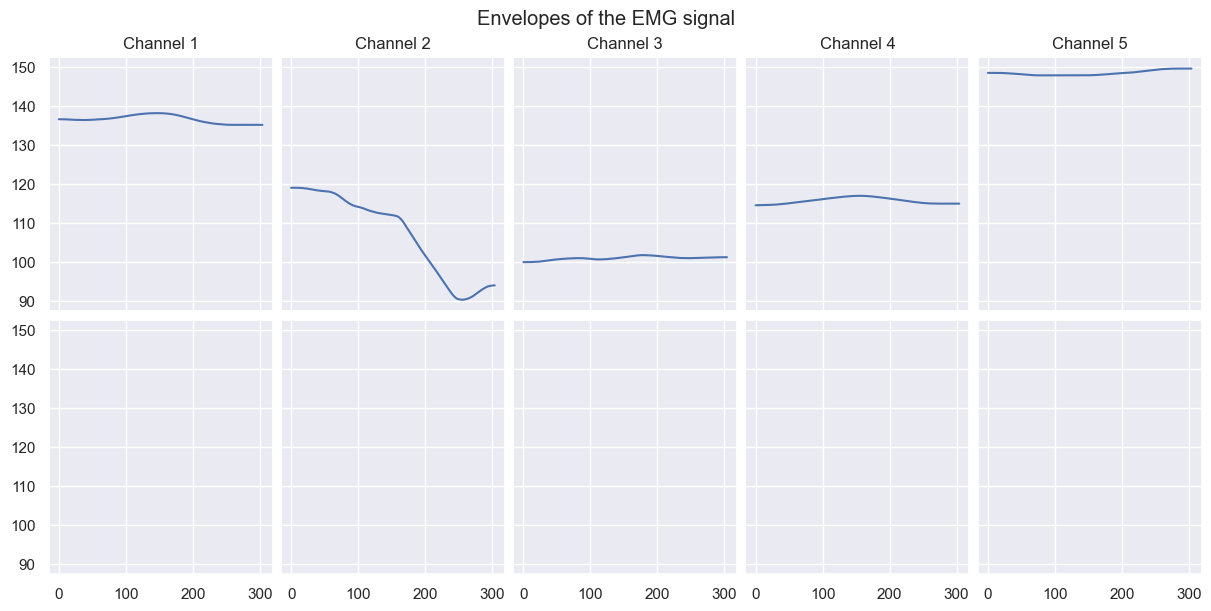

In [12]:
# Plot all the channels on the same y-scale
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg_rectified.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

### 1.4 Visualizing across repetitions

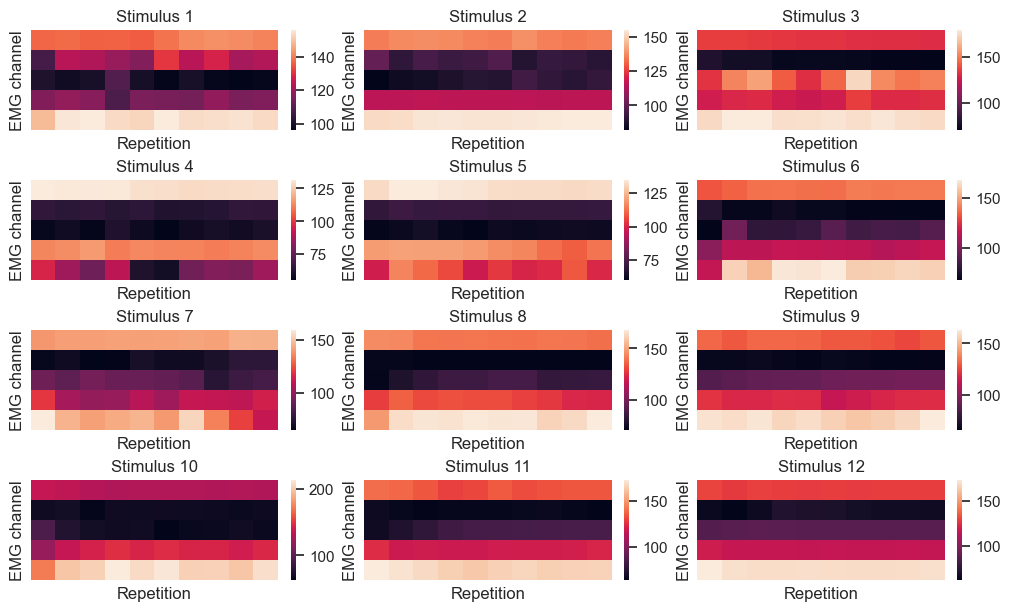

In [13]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

## 2. Split data

In [36]:
reps = np.arange(n_repetitions)
np.random.shuffle(reps)

train_reps = reps[:7]  # First 7 repetitions for training
val_reps = reps[7:9]   # Next 2 repetitions for validation
test_reps = reps[9:]


train_emg = {
    'emg' : emg_rectified[np.isin(repetition.flatten(), train_reps),:],
    'envelopes' :[emg_envelopes[i] for i in train_reps][0],
    'windows' : [emg_envelopes[i] for i in train_reps][0],
    'restimulus' : stimulus[np.isin(repetition.flatten(), train_reps),:],
    'rerepitions' : repetition[np.isin(repetition.flatten(), train_reps),:]
}

val_emg = {
    'emg' : emg_rectified[np.isin(repetition.flatten(), val_reps),:],
    'envelopes' :[emg_envelopes[i] for i in val_reps][0],
    'windows' : [emg_envelopes[i] for i in val_reps][0],
    'restimulus' : stimulus[np.isin(repetition.flatten(), val_reps),:],
    'rerepitions' : repetition[np.isin(repetition.flatten(), val_reps),:]
}

test_emg = {
    'emg' : emg_rectified[np.isin(repetition.flatten(), test_reps),:],
    'envelopes' :[emg_envelopes[i] for i in test_reps][0],
    'windows' : [emg_envelopes[i] for i in test_reps][0],
    'restimulus' : stimulus[np.isin(repetition.flatten(), test_reps),:],
    'rerepitions' : repetition[np.isin(repetition.flatten(), test_reps),:]
}

## 3. Extract features from the trials (at least 5 different ones). 

In [34]:
#before
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

In [ ]:
# Define the features 

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)

#Feel free to add more features, e.g. frequency domain features. (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307)


dataset, labels = build_dataset_from_ninapro(
    emg=emg,
    stimulus=stimulus,
    repetition=repetition,
    features=[mav, std, maxav, rms, wl, ssc] 
    # features=[maxav] 
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")

emg=(101014, 5)
dataset dimension: (120, 30)
dataset=[[136.64528213 107.14459421 101.01094193 ...   0.           0.
    0.        ]
 [137.41552413 123.49509522  98.95193603 ...   0.           0.
    1.        ]
 [135.98119102 122.2074472  100.13957982 ...   1.           0.
    0.        ]
 ...
 [128.40318814  66.00202849  87.         ...   0.           0.
    0.        ]
 [128.4356486   65.82722018  87.         ...   0.           0.
    0.        ]
 [128.4545392   65.51425999  87.         ...   0.           0.
    0.        ]]
labels dimension: (120,)


dataset.shape=(120, 30)
['MAV_1', 'MAV_2', 'MAV_3', 'MAV_4', 'MAV_5', 'STD_1', 'STD_2', 'STD_3', 'STD_4', 'STD_5', 'MaxAV_1', 'MaxAV_2', 'MaxAV_3', 'MaxAV_4', 'MaxAV_5', 'RMS_1', 'RMS_2', 'RMS_3', 'RMS_4', 'RMS_5', 'WL_1', 'WL_2', 'WL_3', 'WL_4', 'WL_5', 'SSC_1', 'SSC_2', 'SSC_3', 'SSC_4', 'SSC_5']


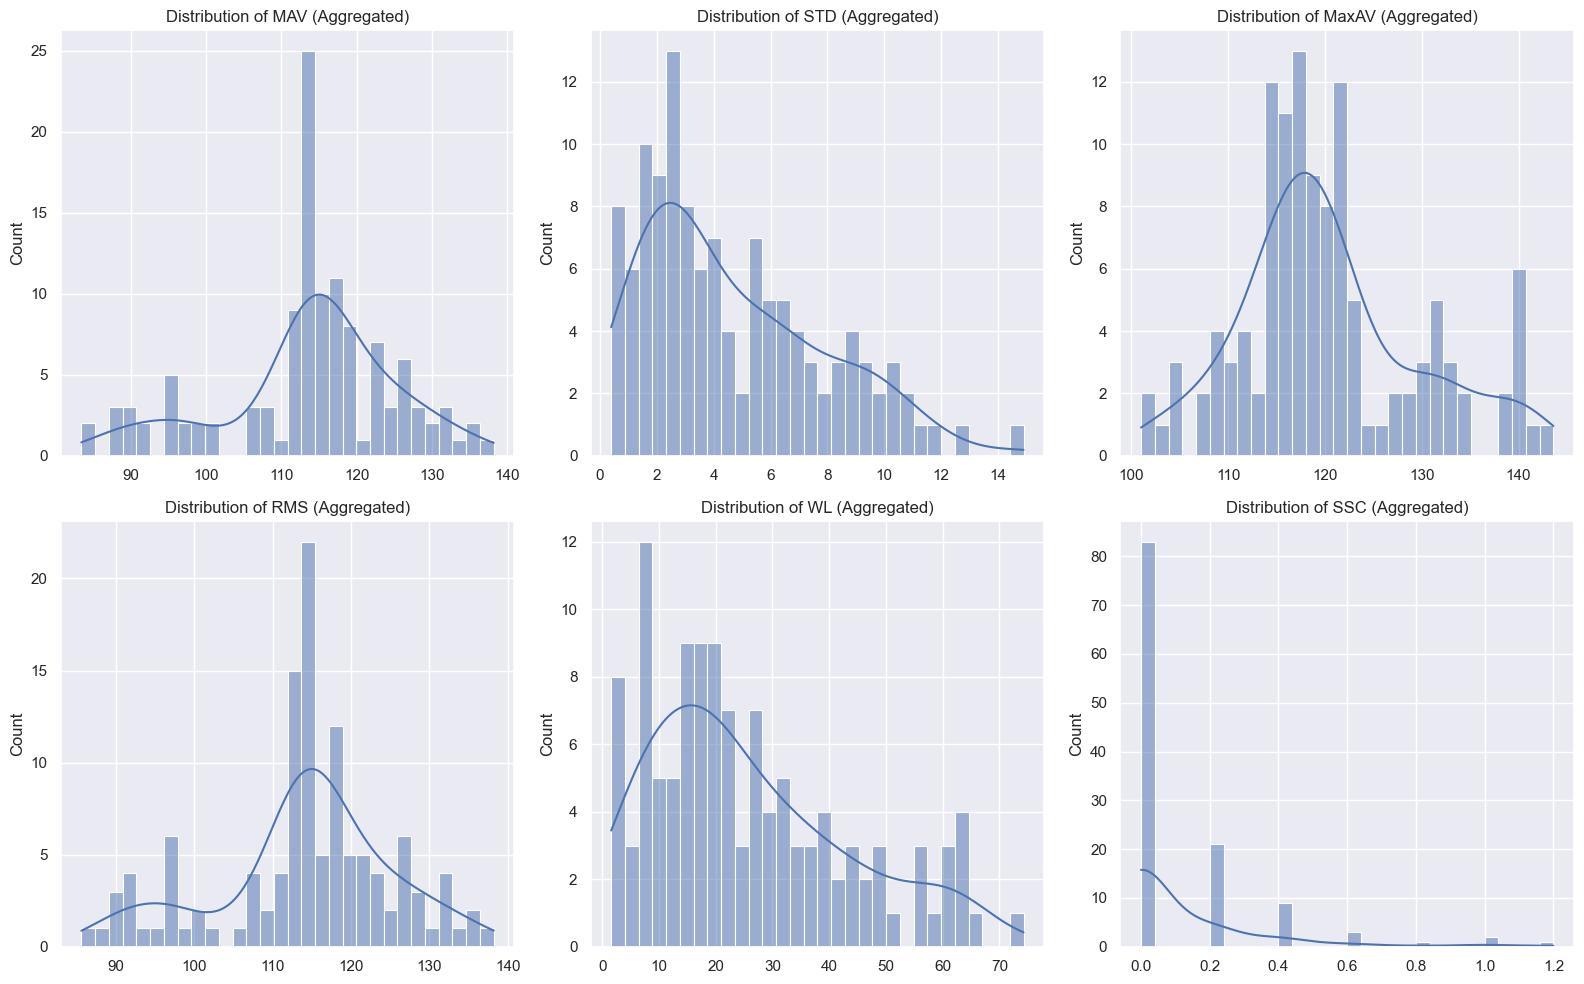

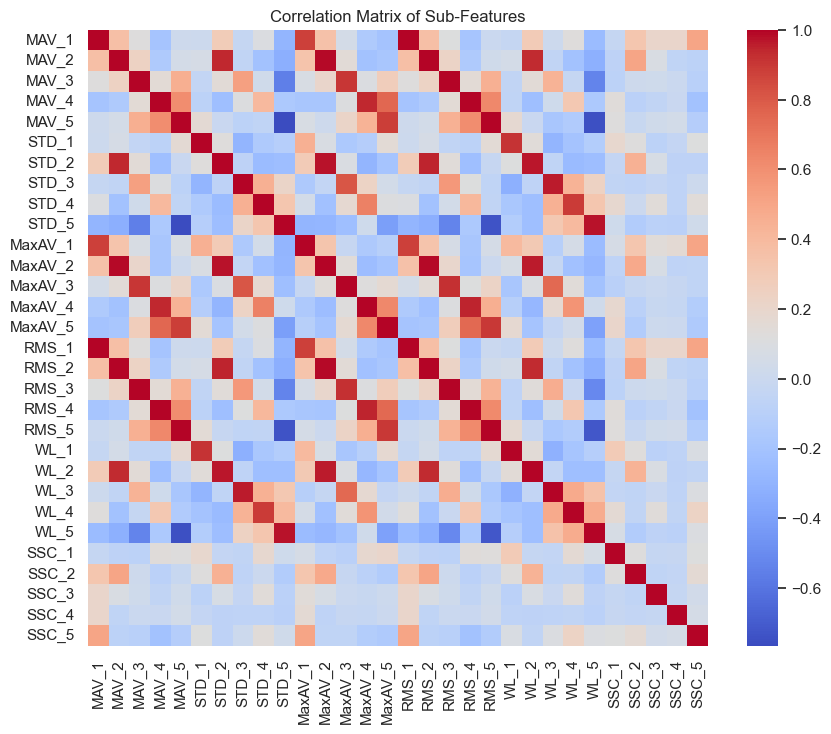

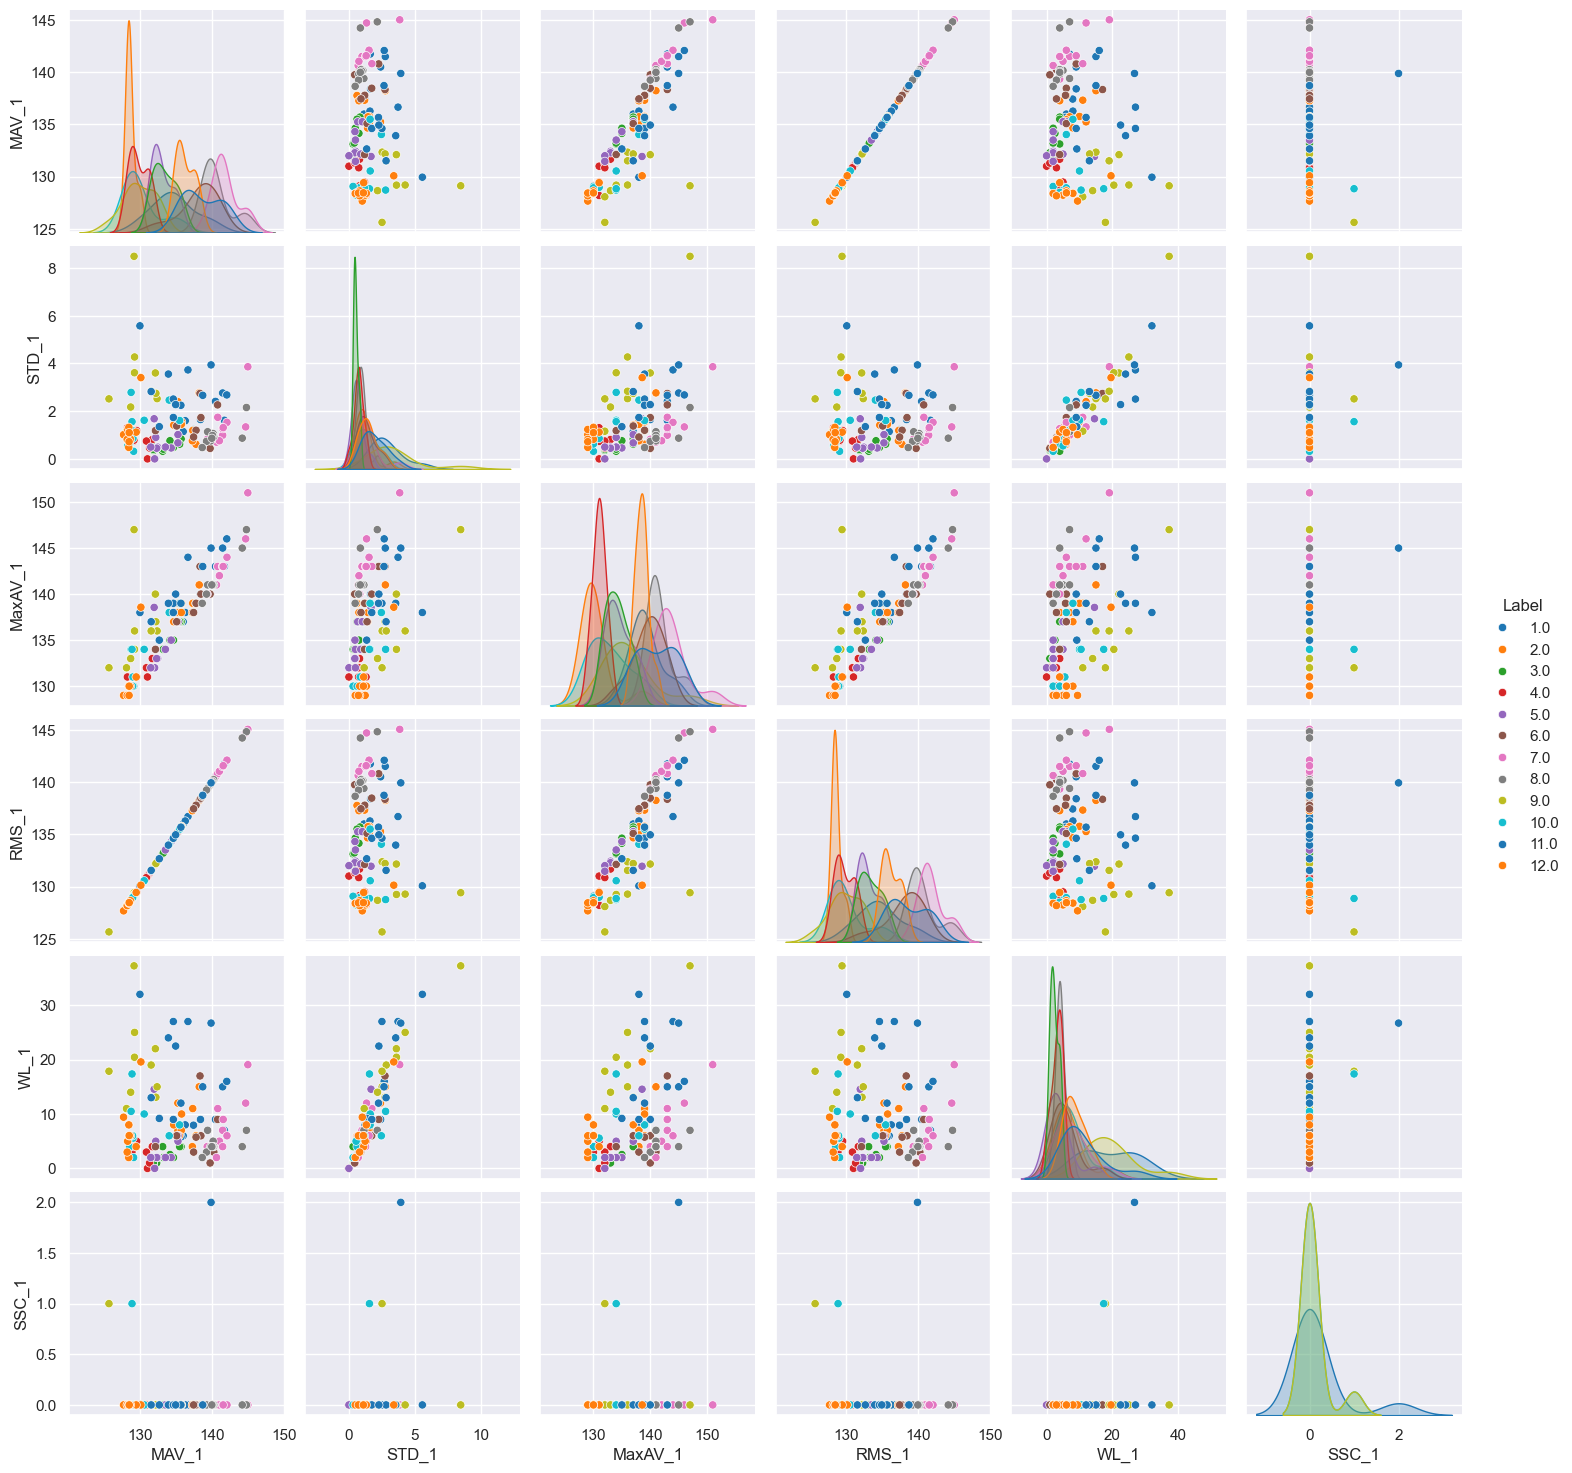

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming `dataset` and `labels` are already built
feature_names = ["MAV", "STD", "MaxAV", "RMS", "WL", "SSC"]
expanded_feature_names = [f"{feature}_{i+1}" for feature in feature_names for i in range(5)]

# Convert dataset into a DataFrame for easy manipulation and visualization
print(f'dataset.shape={dataset.shape}')
print(expanded_feature_names)
df = pd.DataFrame(dataset, columns=expanded_feature_names)
df['Label'] = labels

# 1. Distribution of each main feature (aggregate across sub-features)
plt.figure(figsize=(16, 10))
for i, feature in enumerate(feature_names):
    sub_features = [f"{feature}_{j+1}" for j in range(5)]
    aggregated_values = df[sub_features].mean(axis=1)  # Aggregate sub-feature values
    plt.subplot(2, 3, i + 1)
    sns.histplot(aggregated_values, kde=True, bins=30)
    plt.title(f'Distribution of {feature} (Aggregated)')
plt.tight_layout()
plt.show()

# 2. Correlation Heatmap for all sub-features
plt.figure(figsize=(10, 8))
corr_matrix = df[expanded_feature_names].corr()
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm")  # Set `annot=True` for detailed values
plt.title("Correlation Matrix of Sub-Features")
plt.show()

# 3. Pairplot for selected sub-features (if data size is manageable)
# Use first sub-feature of each type for simplicity
selected_features = [f"{feature}_1" for feature in feature_names]
sns.pairplot(df, vars=selected_features, hue='Label', palette='tab10', diag_kind='kde')
plt.show()


## 4. Perform regression on the data of subject1 - Gradient Boost Decision Tree

Mean Squared Error (MSE): 0.5427
R^2 Score: 0.9455


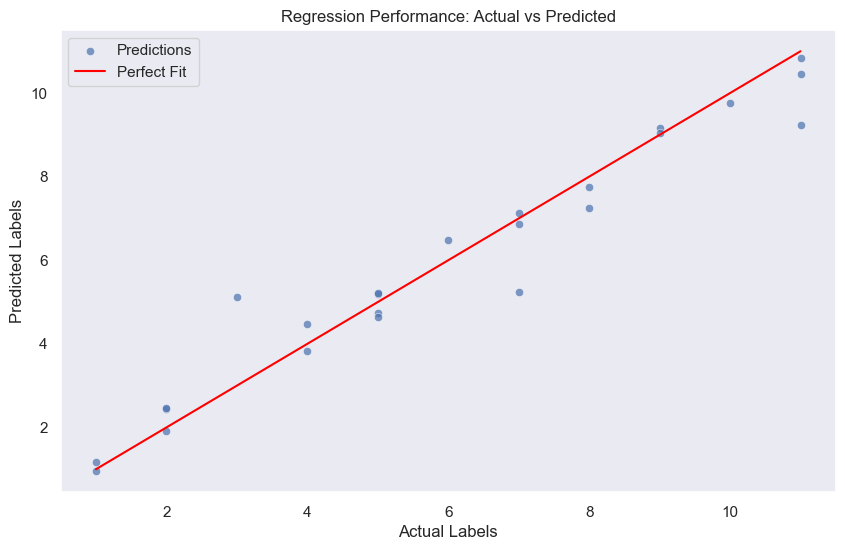

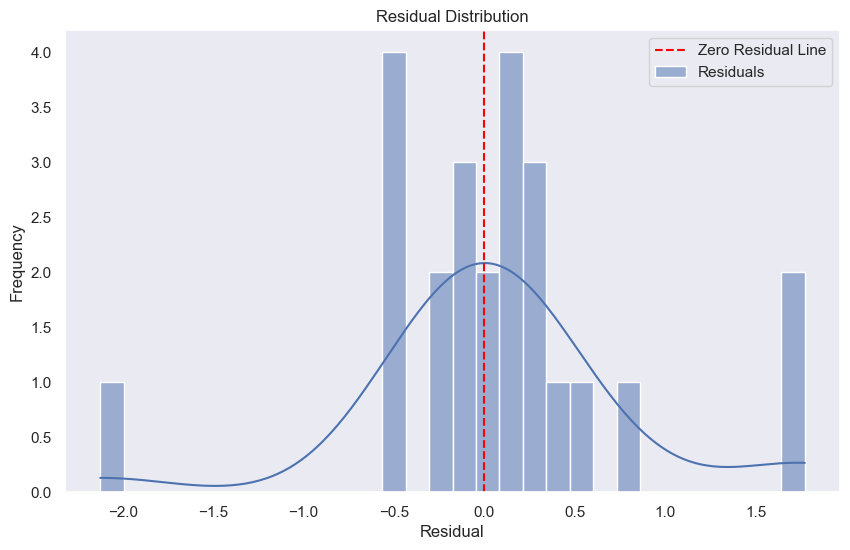

The regressor performs well, capturing most of the variance in the data.


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)

# Define the Gradient Boosting Regressor
regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the regressor on the training data
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Visualize the performance of the regression
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, label='Predictions')
sns.lineplot(x=[min(y_test), max(y_test)], y=[min(y_test), max(y_test)], color='red', label='Perfect Fit')
plt.title('Regression Performance: Actual vs Predicted')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.legend()
plt.grid()
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, label='Residuals')
plt.axvline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.title('Residual Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# Comment on performance
if r2 > 0.7:
    print("The regressor performs well, capturing most of the variance in the data.")
elif r2 > 0.4:
    print("The regressor shows moderate performance. Feature selection or hyperparameter tuning might improve results.")
else:
    print("The regressor has poor performance. Consider improving the feature set or trying a different model.")


### Evaluation of Performance

**Metric Used: Mean Squared Error (MSE) and \(R^2\) Score**

- **MSE Explanation:** Measures the average squared difference between actual and predicted values. It's suitable because it penalizes larger errors more heavily, which is crucial in regression tasks where precision is critical.
- **\(R^2\) Score Explanation:** Indicates how much variance in the target variable is explained by the model. It provides an intuitive understanding of the regression's effectiveness.

#### Justification of the Metrics:
- **MSE:** 
  - Penalizes large deviations, ensuring that the model minimizes significant errors, which is particularly useful when small deviations are tolerable but large ones are not.
  - Provides a clear, interpretable measure of error magnitude in the same scale as the target variable.
- **\(R^2\):**
  - Offers a normalized measure of performance independent of the scale of the target variable, making it easier to compare across different models or datasets.
  - Useful for understanding how well the model generalizes to unseen data.

#### Evaluation of the Performance:
- If \( R^2 > 0.7 \): Indicates that the model explains a significant portion of the variance in the data, suggesting satisfactory performance.
- If MSE is low relative to the range of the finger angles, the model predictions are close to the actual values.



## Stability of Regression Performance Across Different Finger Angles
To evaluate stability, you can compute performance metrics for each finger angle individually and analyze the differences:


#### Observations and Explanations:
- **Stability Across Finger Angles:**
  - If performance metrics (MSE and \( R^2 \)) are consistent across finger angles, the regression model is stable.
  - If substantial differences are observed, these could be attributed to:
    - **Data Imbalance:** Some finger angles might have fewer data points, reducing model accuracy for those angles.
    - **Complexity of Movement:** Certain finger angles might involve more complex or noisier EMG patterns, making them harder to predict.
    - **Signal Overlap:** Signals from different fingers might interfere with each other, leading to poorer performance for closely related angles.

#### Conclusion:
- Use the performance metrics by angle to assess stability.
- If performance is not stable, consider balancing the dataset or incorporating additional preprocessing to address noisy signals or overlapping features.

In [41]:
# Evaluate performance for each unique finger angle
unique_finger_angles = np.unique(labels)

performance_metrics = []

for angle in unique_finger_angles:
    # Select the samples corresponding to the current angle
    idx = labels == angle
    y_test_angle = y_test[idx]
    y_pred_angle = y_pred[idx]
    
    # Compute MSE and R^2 for the current angle
    mse_angle = mean_squared_error(y_test_angle, y_pred_angle)
    r2_angle = r2_score(y_test_angle, y_pred_angle)
    
    performance_metrics.append((angle, mse_angle, r2_angle))

# Convert to DataFrame for easier analysis
import pandas as pd
performance_df = pd.DataFrame(performance_metrics, columns=['Finger Angle', 'MSE', 'R^2'])

# Display the results
import ace_tools as tools; tools.display_dataframe_to_user(name="Performance Metrics by Finger Angle", dataframe=performance_df)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 24 but corresponding boolean dimension is 120